In [1]:
# Import qiskit

import qiskit

In [2]:
# Import all the necessary libraries (not all are necessary but this is what Mohammed had)

from qiskit.aqua.algorithms import VQE, NumPyEigensolver,NumPyMinimumEigensolver
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries, MatrixOp
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import RealAmplitudes
from qiskit.aqua.operators.legacy import WeightedPauliOperator
from qiskit.aqua.operators import (TPBGroupedWeightedPauliOperator,
                                   WeightedPauliOperator,
                                   MatrixOperator)
import warnings
import time

In [3]:
# Import the Hamiltonian from my Mathematica .txt file (which I uploaded to my Jupyter files)

start_time = time.time()
warnings.filterwarnings("ignore")
file_path = fr'./Hbhinterior4x4.txt'
H_file = np.loadtxt(file_path)

HH = MatrixOp(primitive=H_file)
HHH = HH.to_pauli_op()
qubitOp = HHH.to_legacy_op()

# Print some items that gives us info on the Hamiltonian so that we know we did the above step correctly
# Info such as size of Hamiltonian (16x16), number of qubits (4), and how the Hamiltonian is mapped onto the qubits
# It includes the identity matrix, I (beginning of each thing), X gates, Y gates, Z gates (createsd in strings in
# order to represent Hamiltonian)

print("Size of Hamiltonian:", np.shape(H_file))
print(qubitOp)
print(qubitOp.print_details())
type(qubitOp)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime: ',runtime)

Size of Hamiltonian: (16, 16)
Representation: paulis, qubits: 4, size: 7
IIII	(2.5+0j)
IIZZ	(1+0j)
IZIZ	(-0.5+0j)
IZZI	(-1+0j)
ZIIZ	(-1+0j)
ZIZI	(-2+0j)
ZZII	(1+0j)

Program runtime:  0.04314994812011719


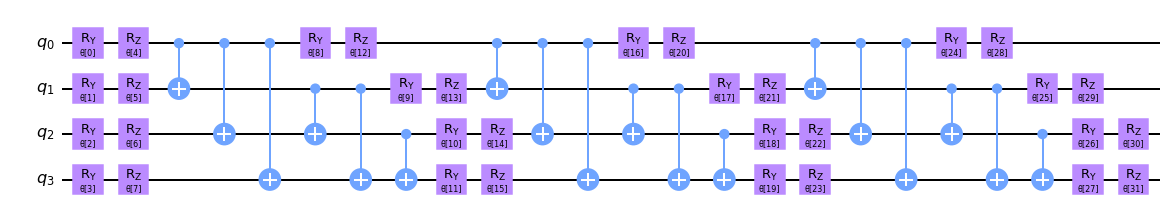

In [4]:
# Next, create the variational form using the function EfficientSU2 (ry variational form)
# Full entanglement measn each qubit is entangled with all the other qubits with a c-not gate
# Reps is the depth of the circuit so each variational form is repeated 3 times (see below 3 sections of blue)

var_form = EfficientSU2(qubitOp.num_qubits,su2_gates=['ry','rz'],entanglement='full',reps=3)

# Display the variational form so that we can see the effect
display(var_form.draw(output='mpl',fold=100))

In [5]:
# Check the exact result that we're getting is correct (i.e. the minimum eigenvalue we'd expect)
# Example: for the SHO we'd expect to get 0.5

exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

Exact Result: [0.]


In [6]:
# This is the VQE algorithm; it takes a while to run sometimes

start_time = time.time()
warnings.filterwarnings("ignore")

# We have to choose a backend and in our case we're using the statevector simulator backend so we define it like this
backend = BasicAer.get_backend("statevector_simulator")
optimizer = SLSQP(maxiter=600)

# Here's some stuff we want to store for plotting later
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# When we want to run our VQE algorithm, we create an object which is an instance of the VQE class
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

# To run the VQE algorithm we use this line of code (this method), where the argument is the backend that we want
ret = vqe.run(backend)

vqe_result = np.real(ret['eigenvalue'])
print("VQE Result:", vqe_result)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime:',runtime, "s")

VQE Result: 2.843255919628e-06
Program runtime: 8.785922050476074 s


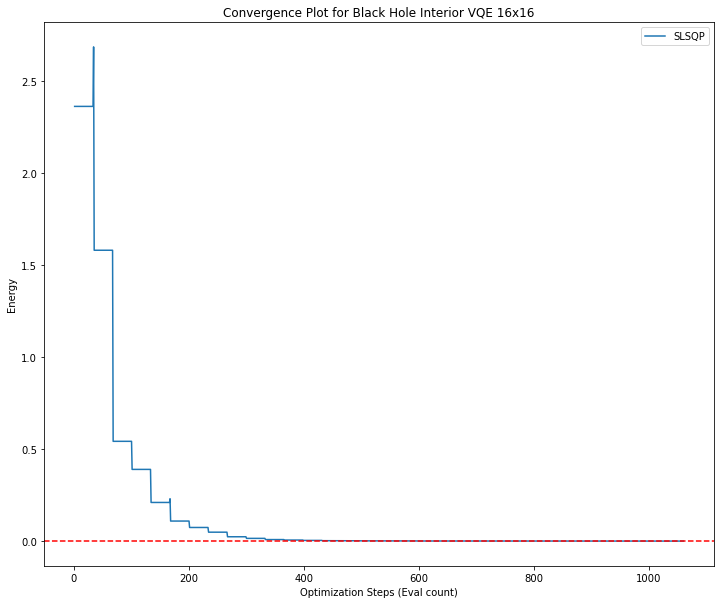

In [8]:
# Plot a convergence plot for the Energy vs optimization steps

plt.figure(figsize=(12,10))
plt.plot(counts, values, label="SLSQP")
plt.xlabel('Optimization Steps (Eval count)')
plt.ylabel('Energy')
plt.title('Convergence Plot for Black Hole Interior VQE 16x16')
plt.legend(loc='upper right')
plt.axhline(np.real(exact_solution.eigenvalues), color='red', linestyle='--')